# 0. Abstract and Outline

The purpose of this document is to briefly introduce the tree-based machine learning models and their application to predicting personal loan acceptance at the universal bank. Decision tree (also called, classification and regression tree, CART) model on one hand, has good interpretability and are computationally light to construct, and on the other hand complex enough to capture the ground truth. Therefore, tree-based models are very widely used in practice to address classification or regression problems. Both the modeling details, the case study, and the Python code are included in this document. 

Below is the outline of this document:

- In [Section 1](#section_1), we discuss the issues of logistic regression and $k$NN for classification problems.

- In [Section 2](#section_2), we introduce the decision tree model.

- In [Section 3](#section_3), we present the Universal Bank personal loan case. 

- In [Section 4](#section_4), we discuss how to fit a decision tree and how to make predictions with a decision tree. These approaches are illustrated with the bank loan case.

- In [Section 5](#section_5), we study regression tree model and implement the model with the the Boston housing price prediction case.

- In [Section 6](#section_8), we give some thoughts on the value of tree-based models in predictive modeling.

<a id='section_1'></a>
# 1. Classification Methods Revisited

Following our convention in the Business Analytics Course, we denote $\mathcal D=\{Y_{i},X_{ij},1\le i\le n,1\le j\le p\}$ as the data at hand, where $Y_i$'s are labels and $X_i$'s are features. For a regression problem, $Y_i$ is a continuous variable; for a classification problem, $Y_i$ is discrete and $Y_i\in\{0,1\}$ in this document. We use $\hat f(\cdot)$ to denote a supervised learning model trained on the data set $\mathcal D$ that maps from feature $X$ to label $Y$. For a classification problem, we use $\hat g(X)$ to denote the estimated positive outcome probability given feature $X$, i.e., $\hat g(X)=\hat{\mathbb P}[Y=1|X]\approx \mathbb P[Y=1|X]$, also trained on $\mathcal D$.

So far we have studied logistic regression and $k$-Nearest Neighbors ($k$NN) models for classification. However, both models have some inherent drawbacks that have kept them from being applicable to some settings/data generating processes. 

- **Logistic regression** model is essentially a linear classifier: We predict $\hat Y_i=1$ if and only if 

$$\hat\beta_0+\sum_{j=1}^p\hat\beta_j X_{ij}\ge \log\left(\frac{t}{1-t}\right),$$
where $\hat \beta=(\hat\beta_0,\hat\beta_1,...\hat\beta_p)$ is the estimated logistic regression coefficient vector, and $t\in(0,1)$ is the threshold value under which the model predicts a posititve outcome if $ \hat{\mathbb P}[Y_i=1|X_i]=\frac{\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_j X_{ij})}{1+\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_j X_{ij})}\ge t$. If the underlying data generating process is inherently nonlinear, the logistic regression model will not make accurate predictions, as illustrated in the following figure. 

<img src="logistic-not-valid.png" width=500>



- **$k-$Nearest Neighbors** model has superior performance when distance in $X$ is a good approximation of similarity in $Y$ and the size of the training set $n$ is large. In this case, nevertheless, $k$NN model is also very slow since it needs to calculate the distance between a new data point to original ones in the training set. Furthermore, $k$NN may suffer from the notorious curse of dimensionality ([Wiki Page](https://en.wikipedia.org/wiki/Curse_of_dimensionality)), i.e., when the feature space's dimension $p$ is high, it requires a huge amount of data to ensure the neighbor of a testing data point has sufficiently many data in the training set.

With these observations, in the next section, we introduce a new approach called **classification and regression tree (CART)** that is flexible enough to be (highly) non-linear and is reasonably fast to perform both training and prediction, thus addressing the issues associated with logistic regression and $k$NN in a smart fashion. 

<a id='section_2'></a>
# 2. Decision Tree Model

The **decision tree** (sometimes also called classification and regression tree, CART, so we use decision tree and CART interchangeably in this course) model mimics the process of making decisions/predictions by a hierarchical series of binary or multiple choice questions. For example, the following figure illustrates a decision tree to predict whether a student has walked to school or taken a bus to school.

<img src="sample-of-a-decision-tree.png" width=750>

For this decision tree, it is quite intuitive to write out the hierarchical decision/prediction rules:

- First, check the weather:
  - If it is sunny, then check the time:
     - If the time is more than 30 minutes, predict the student has walked to school.
     - If the time is less than 30 minutes, predict the student has take a bus to school.
  - If it is cloudy, then check whether the student is hungry:
     - If he is hungry, predict the student has walked to school.
     - If he is not hungry, predict the student has taken a bus to school.
  - If it is rainy, then predict the student has taken a bus to school. 

The decision/prediction process above can be generalized to the classification problem we consider. A tree consists of one or multiple nodes, so that one node has at most parent node and zero or more child nodes. The node that has no parent is called the root node, whereas the node that has no child node is called a leaf node. To simplify notation, we only consider **binary tree** ([Wiki Page](https://en.wikipedia.org/wiki/Binary_tree)) in this document. Specifically, each non-leaf node has at most 2 children. 


- Associated with each leaf node $\tau$ of a decision tree is a subset of data points in the training set (denoted as $\mathcal D(\tau)$), the features of which satisfy all the decision rules of the ancestor nodes of node $\tau$. Clearly, $\mathcal D(\tau)$ for all leaf nodes $\tau$ is a partition of $\mathcal D$. We also define the number of positive outcomes in $\mathcal D(\tau)$ as $n_1(\tau)$, and the number of negative outcomes thereof as $n_0(\tau)$. Hence, the number of data points in $\mathcal D(\tau)$ satisfies that $n(\tau)=|\mathcal D(\tau)|=n_1(\tau)+n_0(\tau)$.


- Associated with each non-leaf node $\tau$ of a decision tree is a binary decision rule: Whether a feature $X_j$ is above a threshold $c_{\tau}$. If $X_j\le c_{\tau}$, go to the left child of $\tau$; otherwise, go to its right child. We also define the data set associated with a non-leaf node $\tau$, denoted by $\mathcal D(\tau)$, as the union of the data sets associated with its left and right children: $\mathcal D(\tau)=\mathcal D(\tau_L)\cup\mathcal D(\tau_R)$, where $\tau_L$ (respectively $\tau_R$) is the left (respectively right) child of $\tau$. We can also recursively define the number of positive (respectively negative) outcomes for each non-leaf node as the sum of its children nodes' number of positive (respectively negative) outcomes: $n_i(\tau)=n_i(\tau_L)+n_i(\tau_R)$ for $i=0,1$. 

From a graphical perspective, a decision tree can be viewed as recursive binary partitioning of the feature space, where each partition is along one feature $X_j$ according to the decision true $X_j\le c_{\tau}$ associated with a non-leaf node $\tau$. In fact these two representations of decision tree are equivalent to each other.

In the following figure, we plot a decision tree of depth 2 with 3 non-leaf nodes and 4 leaf nodes in both the tree prepresentation (the right figure), and the recursive partitioning structure (the left figure). For this case, the first feature is $X[0]$ and the second feature is $X[1]$. The tree first splits on $X[1]\le 0.0596$, and then the left subtree splits on $X[0]\le-0.4177$ whereas the right subtree splits on $X[0]\le 1.1957$.

<img src="tree-illustration.png" width=1000>

As shown in the figure above, we have two equivalent representations of a decision tree. Before discussing how we can fit a decision tree model, and how to use a decision tree model to make predictions, we introduce the case of predicting the personal loan acceptance at Universal Bank. 

<a id='section_3'></a>
# 3. Case: Personal Loan Acceptance at Universal Bank

Universal Bank is going to run a campaign to offer a personal loan product to its customers. The bank would like to improve its campaign strategy, based on the acceptance data from a previous campaign. In the previous campaign, only about 4.8% of the customers actually accepted the loan offer. The data was collected on a sample of 5000 customers in the previous campaign. 

The central problem of interest is that **How to accurately predict the who will actually accept the offer in the new campaign?** 

The list of variables in the previous campaign data set is given as follows:

- **Age**: Customer's age
- **Experience**: Number of years of professional experience
- **Income**: Annual income of the customer (in 1,000 dollars)
- **Family Size**: Family size of the customer
- **CCAvg**: Average spending on credit cards per month (in 1,000 dollars)
- **Education**: Education level, 1 means undergrad or lower; 2 means graduate; 3 means doctoral or professional
- **Mortage**: Value of house mortage (in 1,000 dollars)
- **Securities Account**: 1 means the customer has securities account with the bank; 0 means otherwise
- **CD Account**: 1 means the customer has certificate of deposit (CD) account with bank; 0 means otherwise
- **Online Banking**: 1 means the customer uses internet banking facilities; 0 means otherwise
- **Credit Card**: 1 means the customer uses credit card issued by University Bank; 0 means otherwise
- **Personal Loan (outcome variable)**: 1 means the customer accepted the offer; 0 means otherwise

To begin with, we load the bank loan data, and take a look at the first few rows. 

In [1]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
import random

# Set the random seed such that the results are replicable.

random.seed(666)

In [2]:
df_bank_loan  = pd.read_csv("UniversalBank.csv")

df_bank_loan.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


As in all other supervised learning projects， we first randomly split the data into training and validation sets, with 70% of the data into the training set and the rest into the testing set.

In [3]:
from sklearn.model_selection import train_test_split as tr_te_split

X = df_bank_loan.drop(columns=['Personal.Loan'])
y = df_bank_loan['Personal.Loan'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

<a id='section_4'></a>
# 4. Fitting and Predicting with a Decision Tree

In this section, we discuss how to fit a decision tree and how to use a decision tree to make predictions.

## 4.1. Fitting a Decision Tree

Next, we study how to use our training set $\mathcal D=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j\le p\}$ to fit a decision (for classification) and to predict both the conditional probability $\hat g(X)=\hat{\mathbb P}[Y=1|X]$ and the outcome $\hat f(X)=\hat{Y}$ with a decision tree, given the feature $X$. To avoid the weird case that two observations with the same feature lead to different outcomes, we assume that, for two data points $(X_{i_1},Y_{i_1}),(X_{i_2},Y_{i_2})\in\mathcal D$, if $Y_{i_1}\ne Y_{i_2}$, we always have $X_{i_1}\ne X_{i_2}$.

We first address the training problem. Recall that our objective is to make predictions with the decision tree. Therefore, in order that the decision tree could best serve the prediction purposes, we want its leaf nodes to be as informative as possible, or as "pure" as possible. By pure we mean that the labels of the data points in each leaf are as imbalanced as possible, i.e., each leaf node has a lot of positive outcomes and very few negative ones, or a lot of negative outcomes and very few positive ones. 

In addition, note that, if we do not have any constraint on the structure of the tree, it is always possible to train a decision tree such that all the leaf nodes are completely pure, i.e., all data points in the same leaf node are with the same outcome (Why? You may argue by contradiction. If this is not true, you can always split the tree further until all leaf nodes are pure.) With this observation, we would like the tree not to grow too large. An extensive tree is likely to **overfit** the training data.

Therefore, we seek to build a decision tree based on the data $\mathcal D$ that is

- **Maximally compact (to avoid overfitting);**
- **All the leaf nodes are as pure as possible (to capture the ground truth).**

Essentially, to make the tree as compact as possible is to reduce overfitting and variance, whereas to increase the tree purity is to reduce underfitting and bias. Therefore, fitting a tree requires a smart balance between bias and variance. Under a unified regularization frame, to fit a tree $\hat f(\cdot)$ is to find the optimal classification tree model such that

<font color=red>
$$\hat f(\cdot)=\mbox{argmin}_{f(\cdot)\in\mathcal F}\Big[\frac{1}{n}\underbrace{\sum_{i=1}^n\mathcal L(Y_i,f(X_i))}_{\mbox{Loss/impurity}}+\underbrace{R(f)}_{\mbox{Penalty/Complexity}}\Big]$$
</font>

where $\mathcal L(\cdot,\cdot)$ is a general loss/impurity function, and $R(f)$ penalizes overly complex trees, and $\mathcal F$ is the set of all classification trees. In particular, for the case of building a decision tree with complexity parameter $cp$ (see the Python code below), $R(f)=cp \cdot T$, where $T$ is the number of leaves in the tree $f$. This implies that each additional leaf should decrease the loss/impurity by at least $cp$. Otherwise, the total loss will actually increase.

The bad news is the above optimization problem to exactly build a maximally compact and pure tree is NP-hard ([Wiki Page](https://en.wikipedia.org/wiki/NP-hardness)). However, we have good news that this can be well approximated with an efficient greedy heuristic strategy for recursive partitioning. The idea of the heuristic is that we iteratively grow the tree from a root node so that each split from a parent node to two children nodes would increase the (current) purity of each leaf to the largest extent possible. 

To measure (im)purity, we usually use Gini Index ([Wiki Page](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)) or information entrophy ([Wiki Page]( https://en.wikipedia.org/wiki/Entropy_(information_theory) )) as the metric. Both metrics will decrease if the node is purer.

- **Gini Index:** The Ginni Index of a leaf node $\tau$ is given by:
<font color=red>
$$G(\tau)=\sum_{k=0}^1p_k(1-p_k),$$
</font>    
where $p_k$ is the proportion of data points in $\tau$ with outcome $Y=k$ ($k=0,1$). For example, if $\tau$ has 10 data points, 3 with positive outcome, 7 with negative outcome, then $p_0=0.7$, $p_1=0.3$, and $G(\tau)=0.7\cdot(1-0.7)+0.3\cdot(1-0.3)=0.42$. The Gini Index of a non-leaf node $\tau$ is given recursively by:
<font color=red>
$$G(\tau)=\frac{|\tau_L|}{|\tau|}G(\tau_L)+\frac{|\tau_R|}{|\tau|}G(\tau_R),$$
</font>
where $|\cdot|$ denotes the total number of data points in this node.  

- **Information entropy:** The information entropy of a leaf node $\tau$ is given by:
<font color=red>
$$E(\tau)=-\sum_{k=0}^1p_k\log(p_k).$$
</font>
For example, if $\tau$ has 10 data points, 3 with positive outcome, 7 with negative outcome, then $p_0=0.7$, $p_1=0.3$, and $E(\tau)=-0.7\cdot\log(0.7)-0.3\cdot\log(0.3)=0.611$. The information entropy of a non-leaf node $\tau$ is defined in a similar fashion as the Gini Index:
<font color=red>
$$E(\tau)=\frac{|\tau_L|}{|\tau|}E(\tau_L)+\frac{|\tau_R|}{|\tau|}E(\tau_R).$$
</font>
Using either Gini Index or information entropy, we summarize the recursive splitting heuristic to build a decision tree as follows (below we use Gini Index as an example, but the same framework applies to information entropy). 

-----

<font color=red>

- **Initialization and input:** All the data $\mathcal D$ are put in the root node. Input the stopping criteria (such as max tree depth and complexity parameter, which is the minimum decrease in Gini Index of each recursive split).
- **Step 1:** For each leaf node $\tau$, split this node into two children nodes according to cutoffs in each feature $X_j$ and compute the Gini Index of each resulting tree.
- **Step 2:** Of the new trees constructed in Step 1, pick up the one with the smallest Gini Index, denoted as $\hat T^*$. If $\hat T^*$ satisfies the stopping criteria, then stop and **Output $\hat T^*$**. Otherwise, repeat **Step 1**. 

</font>

-----


We highlight that, on one hand, the recursive splitting procedure to iteratively decrease the tree impurity seeks to enhance the model complexity and flexibility in order to **reduce model bias**. On the other hand, all of the stopping criteria, such as the **maximum tree depth**, the **minimum impurity decrease of each split**, or the **minimum size of each leafnode**, are imposed to control the model complexity of the fitted tree so as to **avoid overfitting** and to **control the model variance**. 

Let us now illustrate the above recursive partition procedure with the bank loan case. We consider two features: **Income** (annual income) and **CCAvg** (average spending on credit cards). The data set can be plotted as follows:  

<img src="Tree-0.png" width=750>

Then, by calculating the Gini Index for each split on both the Income feature and the CCAvg feature, the tree with the **smallest Gini Index** is to split at **Income=114**. We plot as follows: 

<img src="Tree-1.png" width=750>

Next, we calculate the Gini Index for each split on both the Income feature and the CCAvg feature, the tree with the **smallest Gini Index** is to split the left node (Income<114 on the first split) at **CCAvg=3** and the right node (Income$\ge$114 on the first split) at **Income=164**. We plot as follows: 

<img src="Tree-2.png" width=750>

Then, we stop because the stopping criterion is met. This classification tree can also be plotted under the tree structure as follows:

<img src="Tree-3.png" width=750>

In this figure, the numbers in each leaf node within the red block are the predicted positive outcome probabilities for a new data point in each leaf node, i.e., $\hat{\mathbb P}[Y=1|X]$, which we will discuss later. 

An important interpretation associated with the decision tree model is that nodes close to the root are the most important factor(s). The above tree implies that income is the most critical factor that influences the acceptance of the personal loan.

## 4.2. Fitting a Decision Tree for the Bank Loan Case

We now discuss how to implement a decision tree model  with the University Bank Personal Loan case. We first install and load necessary packages for fitting and plotting a tree. See this [documentation](https://scikit-learn.org/stable/modules/tree.html) for more details.

In [4]:
## Import necessary packages to fit the classification tree 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

Then, we train a a decision tree using the training set and plot it.

In [5]:
loan_tree =  DecisionTreeClassifier(max_depth=3,ccp_alpha = 0.01) 
# max_depth is the maximum depth
# ccp_alpha is the complexity parameter
loan_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=3)

[Text(133.92000000000002, 190.26, 'X[2] <= 113.5\ngini = 0.174\nsamples = 3500\nvalue = [3163, 337]'),
 Text(66.96000000000001, 135.9, 'gini = 0.034\nsamples = 2813\nvalue = [2764, 49]'),
 Text(200.88000000000002, 135.9, 'X[5] <= 1.5\ngini = 0.487\nsamples = 687\nvalue = [399, 288]'),
 Text(133.92000000000002, 81.53999999999999, 'X[3] <= 2.5\ngini = 0.187\nsamples = 432\nvalue = [387, 45]'),
 Text(66.96000000000001, 27.180000000000007, 'gini = 0.0\nsamples = 387\nvalue = [387, 0]'),
 Text(200.88000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 45\nvalue = [0, 45]'),
 Text(267.84000000000003, 81.53999999999999, 'gini = 0.09\nsamples = 255\nvalue = [12, 243]')]

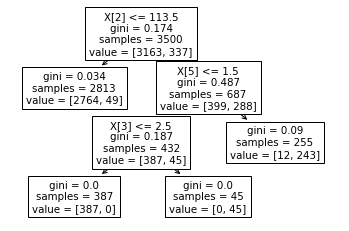

In [6]:
## Plot the tree

plot_tree(loan_tree)

## 4.3. Predicting with a Decision Tree 

This subsection is devoted to discussing how we can make predictions on new data with the decision tree $T$ trained on $\mathcal D$. For a new data point $(Y,X)$, the decision tree $\hat T$ will uniquely prescribe (by following the decision rules) which leaf node $\tau$ the feature $X$ belongs to, which is generally very fast. Assume that, for the training data that are in node $\tau$, there are $n_1(\tau)$ positive outcomes and $n_0(\tau)$ negative outcomes. We predict that the conditional probability of positive outcome is

<font color=red>
$$\hat g(X)=\hat{\mathbb P}[Y=1|X]=\frac{n_1(\tau)}{n_1(\tau)+n_0(\tau)}$$
</font>
    
For instance, a leaf node $\tau$ has 100 data points in $\mathcal D$, of which 80 are with a positive outcome ($Y=1$) and 20 are with a negative outcome ($Y=0$), then for any $X\in\tau$, we have $\hat g(X)=\hat{\mathbb P}[Y=1|X]=0.8$. 

Similar to the cases of logistic regression and $k$NN, with the predicted conditional probability of a positive outcome $\hat g(X)=\hat{\mathbb P}[Y=1|X]$, we can construct a classifier using the threshold approach:

$$\hat Y=\hat f(x)=
\begin{cases}
1,\mbox{ if }\hat g(X)\ge t\\
0,\mbox{ otherwise}
\end{cases}
$$
where $t\in[0,1]$ is the threshold for the classifier $\hat f(\cdot)$. Then, all the common out-of-sample tricks/evaluation metrics such as confusion matrices, overall accuracy, 0-1 Loss, precision, recall, false-positive rate, false-negative rate, ROC, and AUC, etc. can be computed, and the generalization error/performance can be estimated using a testing set.  

## 4.4. Predicting and Evaluating a Decision Tree for the Bank Loan Case

We now make predictions on the validation set and evaluate the decision tree trained on the training set for the Bank Loan Case.

First, we predict $\hat g(X)=\hat{\mathbb P}[Y=1|X]$ on the validation set.

In [7]:
y_pred = loan_tree.predict(X_test)

In [8]:
def printCM(tn, fp, fn, tp):
    print('{: <9} {: <9} {: <9}'.format(' ',' ','predicted'))
    print('         --------------------')
    print('{: <9}|{: <9d}|{: <9d}'.format('Actual',0,1))
    print('-----------------------------')
    print('{: <9d}|tn={: <6d}|fp={: <9d}'.format(0,tn,fp))
    print('-----------------------------')
    print('{: <9d}|fn={: <6d}|tp={: <9d}'.format(1,fn,tp))

In [9]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
printCM(tn, fp, fn, tp)

                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=1352  |fp=5        
-----------------------------
1        |fn=35    |tp=108      


The **Confusion Matrix** is printed by our self-defined function, which creates a confusion matrix with common metrics for a classification model. One should note that this function put the actual outcomes as different columns and the predicted outcomes as rows. 

Finally, we draw the ROC curve and compute the AUC.

The out-of-sample AUC is 0.8922.


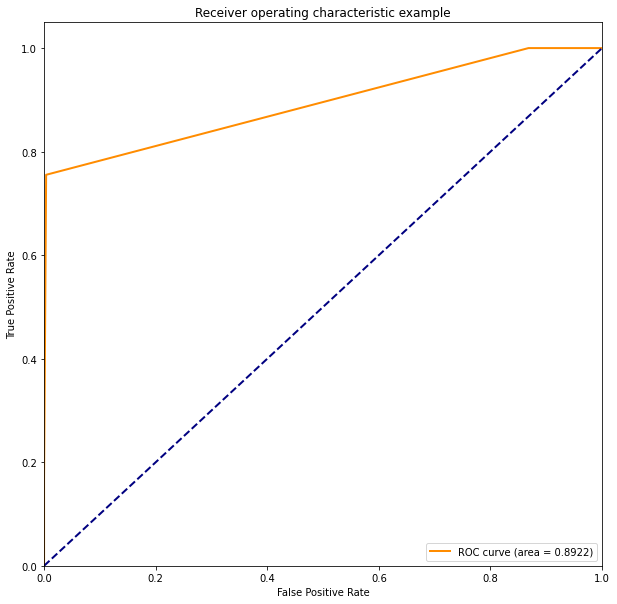

In [10]:
from sklearn.metrics import  roc_curve, auc
y_score=loan_tree.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_score[:,1])
roc_auc =auc(fpr,tpr)
print("The out-of-sample AUC is %0.4f."% roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The main conclusion from our decision tree out-of-sample analysis is that this model has very strong predictive power. 

<a id='section_5'></a>
# 5. Regression Tree

For the problem with a continuous outcome variable $Y$, the decision tree trained on the data set $\mathcal D=\{Y_{i},X_{ij},1\le i\le n,1\le j\le p\}$ is called a regression tree. When fitting a regression tree, the main idea is still to recursively split the feature space so that each split could increase the (current) purity of the tree to the largest possible (or to reduce the impurity to the most). The impurity metric we use to train a regression tree is the squared loss. 

- The squared loss a leaf node $\tau$ is given by:
<font color=red>
$$\mathcal L(\tau)=\frac{1}{|\tau|}\sum_{(X,Y)\in\mathcal D(\tau)}(Y-\bar{Y}_{\tau})^2,\mbox{ where }\bar Y_{\tau}:=\frac{1}{|\tau|}\sum_{(X,Y)\in \mathcal D(\tau)}Y\mbox{ is the mean outcome of the node }\tau$$
</font>    
The squared loss of a non-leaf node $\tau$ is given recursively by:
<font color=red>
$$\mathcal L(\tau)=\frac{|\tau_L|}{|\tau|}\mathcal L(\tau_L)+\frac{|\tau_R|}{|\tau|}\mathcal L(\tau_R)$$
</font>

Therefore, we could fit a regression with the following recursive partition:


-------
<font color=red>

- **Initialization and input:** All the data $\mathcal D$ are put in the root node. Input the stopping criteria (such as **max tree depth** and/or **complexity parameter**, which is the minimum decrease in squared loss of each recursive split).
- **Step 1:** For each leaf node $\tau$, split this node into two children nodes according to cutoffs in each feature $X_j$ and compute the squared loss of each resulting tree.
- **Step 2:** Of the new trees constructed in Step 1, pick up the one with the smallest squared loss, denoted as $\hat T^*$. If $\hat T^*$ satisfies the stopping criteria, then stop and **Output $\hat T^*$**. Otherwise, repeat **Step 1**. 

</font>

---------
    
So the above procedure gradually grows a tree until some stopping criteria are met. A regression tree (same thing applies to a classification tree) may overfit the training data when it is too complex, as illustrated by the following figure. Therefore, we may want to prune a tree (i.e., to remove some leaves) to reduce over-fitting.

<img src="RT.png" width=600>


Next, we discuss how to make predictions on new data with the regression tree $\hat T$ trained on $\mathcal D$. For a new data point with feature $X$, the decision tree $\hat T$ will uniquely prescribe which leaf node $\tau$ the feature $X$ belongs to. We predict that the outcome given feature $X$ is

<font color=red>
$$\hat Y=\hat f(X)=\bar Y_{\tau}=\frac{1}{|\tau|}\sum_{(X,Y)\in \mathcal D(\tau)}Y,$$
</font>
which is the expected outcome of the data points in the training set and in node $\tau$.


Similar for linear regression all the common out-of-sample evaluation metrics such as rooted-mean-squared-error, $R^2$, and mean-absolute-error, etc. can be computed, and the generalization error/performance can be estimated using a testing set. 

We also remark that the regression tree model is essentially a step-function model, illustrated as below, where the outcome $Y$ is a user's interest on a specic news topic, and the feature is time, denoted by $t$. The recursive splitting process essentially strikes a balance between bias (measured by the squared loss impurity, denoted as $L(f)$ in the figure below) and variance (measured by the model complexity, denoted as $\Omega (f)$ in the figure below). To many splits will decrease the bias but increase the variance of a regression model.

<img src="RT-Step.png" width=1000>

Finally, we remark that a regression tree $\hat f(X)$ can be represented as 

<font color=red>

$$\hat f(X)=\sum_{\tau=1}^T w_{\tau}1\{X\in\mathcal X(\tau)\}$$

</font>
where $w_{\tau}$ is the predicted outcome associated with leaf $\tau$ and $X(\tau)$ is the subset of the feature space associated with the leaf $\tau $, and $T$ is the total number of leaves.

## 5.1. Regression Tree for Boston Housing Price Prediction

Let us revisit the Boston housing data set. This data set contains the following variables:

- **CRIM**: Per capita crime rate
- **ZN**: How much of the land is zoned for large residential properties
- **INDUS**: Proportion of the area used for industry
- **CHAS**: Binary variable, 1 if a census tract is next to the Charles River
- **NOX**: Concentration of nitrous oxides in the air, a measure of air pollution
- **RM**: Average number of rooms per dwelling
- **AGE**: Proportion of owner-occupied units built before 1940
- **DIS**: Measure of how far the tract is from centers of employment in Boston
- **RAD**: Measure of closeness to important highways
- **TAX**: Property tax per 10,000 dollars of value
- **PTRATIO**: Pupil to teacher ratio by town
- **TRACT**: Index of the tract
- **lstat**: The percentage of homeowners in the neighborhood considered "lower class" (working poor). 
- **MEDV (outcome variable)**: Median value of owner-occupied homes, measured in thousands of dollars

We use the regression tree model to predict the price. To begin with, we load the data.

In [12]:
df_BH = pd.read_csv("BostonHousing.csv")
df_BH.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Next, we split the data into training (70%) and testing (30%) sets.

In [13]:
from sklearn.model_selection import train_test_split as tr_te_split
X = df_BH.drop(columns=['medv'])
y = df_BH['medv'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

We now fit a regression tree model on the training set.

In [14]:
from sklearn.tree import DecisionTreeRegressor
BH_tree = DecisionTreeRegressor(ccp_alpha=0.005)
BH_tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.005)

[Text(164.8434184537246, 210.645, 'X[12] <= 7.865\nsquared_error = 77.846\nsamples = 354\nvalue = 21.834'),
 Text(82.5663656884876, 197.055, 'X[5] <= 7.433\nsquared_error = 74.391\nsamples = 101\nvalue = 31.347'),
 Text(50.25778781038375, 183.465, 'X[0] <= 3.121\nsquared_error = 33.455\nsamples = 81\nvalue = 28.265'),
 Text(48.24243792325057, 169.875, 'X[5] <= 6.782\nsquared_error = 22.04\nsamples = 79\nvalue = 27.715'),
 Text(21.916930022573364, 156.285, 'X[5] <= 6.428\nsquared_error = 9.188\nsamples = 50\nvalue = 25.118'),
 Text(12.092099322799097, 142.695, 'X[12] <= 7.695\nsquared_error = 2.593\nsamples = 25\nvalue = 23.052'),
 Text(10.076749435665915, 129.10500000000002, 'X[2] <= 6.115\nsquared_error = 1.253\nsamples = 23\nvalue = 23.404'),
 Text(6.0460496613995485, 115.515, 'X[1] <= 81.25\nsquared_error = 1.184\nsamples = 10\nvalue = 22.86'),
 Text(4.030699774266366, 101.925, 'X[9] <= 252.5\nsquared_error = 0.717\nsamples = 8\nvalue = 22.475'),
 Text(2.015349887133183, 88.33500000

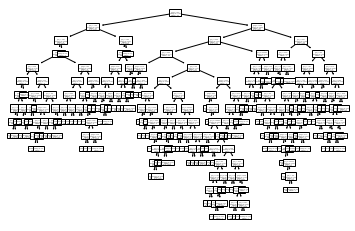

In [15]:
## Plot the tree

plot_tree(BH_tree)



Next, we make predictions on the validation set and compute the out-of-sample $R^2$.

In [16]:
print("The out-of-sample R-squared of the regression tree is %0.4f." % BH_tree.score(X_test,y_test))

The out-of-sample R-squared of the regression tree is 0.6242.


<a id='section_8'></a>
# 6. Concluding Remarks

Finally, we conclude this document with some brief discussions on when we should use tree-based models:

- Trees are non-linear. So, if there is some intrinsic non-linear relationship between the features and the label, using tree-based models are recommended. In particular, trees leverage a clever data structure that makes the $k$NN idea scalable.

- Because of the feature space splitting rule, tree-based models are not sensitive to scaling, so featuring engineering is not that important.

- A single CART is generally very interpretable, but may suffer from the overfitting problem. We can finetune a lot of parameters to avoid overfitting.